In [2]:
import numpy as np # using version 1.22.4 as the newer version unsuitable for stable baselines 3
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import math
from stable_baselines3 import PPO
import os
import matplotlib.pyplot as plt

In [3]:
## Rastrigin Function and its directional derivatives

def ras(cord, A, B, C):
    n = cord.shape[0]
    cord = np.atleast_2d(cord).T  #Transpose 

    res = np.linalg.norm( A@cord - B )
    res = 0.5 * (res ** 2)

    angle = np.array(2 * math.pi * cord)
    tri = C@np.cos(angle)

    res = res - tri + n
  
    return res[0][0]


def grad_ras(cord, A, B, C):
    n = cord.shape[0]
    cord = np.atleast_2d(cord).T  #Transpose 

    Anew = A.copy()
    res = Anew@cord - B

    res = np.append(res, [[2 * math.pi]])
  
    tri = np.sin(2 * math.pi * cord)
  
    a = C@tri
  
    val = np.full((n, 1), a[0][0])
  
    Anew = np.hstack((Anew, val))
 
    res = Anew@res
  
    return res

In [6]:
# Parameters

n = 3  # Number of dimensions of the function

# Observation space limits
HIGH = 10000
LOW = -10000

# Limits of the area in which initialization will take place
INIT_HIGH = 10 
INIT_LOW = -10

PREV = 25 # number of previous iterates to consider as states

MAX_STEP = 1000 # maximum number of steps per episode, trancation if still not converged

COUNTER = 10 # maximum number of episodes for a set of parameters

# Initialization of the A,B,C parameters of the Rastrigan-like function
A = np.array(np.random.normal(0, 1, size = (n, n)), dtype = np.float32)
B = np.array(np.random.normal(0, 1, size = (n, 1)), dtype = np.float32)
C = np.array(np.random.normal(0, 1, size = (1, n)), dtype = np.float32)

TOLERANCE = 1e-5 # if the change is lower than this then the episode will terminate

BOUNDARY_PENALTY = -10000 # reward if point goes outside the boundary
MAX_GRADIENT = 10000

In [7]:
# Custom environment

class L2O_RL(gym.Env):
    
    def __init__(self, n, HIGH, LOW, INIT_HIGH, INIT_LOW, PREV, MAX_STEP, COUNTER, A, B, C, TOLERANCE, BOUNDARY_PENALTY, MAX_GRADIENT):
        super(L2O_RL, self).__init__()
        
        # Variables
        self.n = n
        self.prev = PREV
        self.dim = (n+1)*PREV 
        
        self.high = HIGH
        self.low = LOW
        self.init_high = INIT_HIGH
        self.init_low = INIT_LOW
        
        self.step_no = 0
        self.max_step = MAX_STEP
        self.counter = COUNTER
        self.max_counter = COUNTER
        
        self.A = A
        self.B = B
        self.C = C
        
        self.tolerance = TOLERANCE
        self.boundary_penalty = BOUNDARY_PENALTY
        self.max_gradient = MAX_GRADIENT
    
        # Spaces
        self.observation_space = spaces.Box(low = LOW, high = HIGH, shape=(self.dim,), dtype = np.float32)
        self.action_space = spaces.Box(low = LOW, high = HIGH, shape=(self.n,), dtype = np.float32)
        
        # State
        self.cord = np.random.uniform(self.init_low, self.init_high, self.n) # Random Initialization of the starting point
        self.grad = grad_ras(self.cord, self.A, self.B, self.C) # Gradient at that point
        self.value = ras(self.cord, self.A, self.B, self.C)
        
        self.observation = np.zeros(self.dim, dtype = np.float32)
        for j in range(self.prev):
            for i in range(self.n):
                self.observation[self.prev+i+j*n] = self.grad[i] # initializing with all gradients
            
            
        
    def step(self, action):
        self.cord = self.cord + action
        
        self.grad = grad_ras(self.cord, self.A, self.B, self.C) # gradient at the new coordinates
        newvalue = ras(self.cord, self.A, self.B, self.C) # calculate new value
        
        terminated = False
        truncated = False
        info = {}
        
        boundary_flag = False
        
        # check if the coordinates and function value are out of the limits
        for i in range(self.n):
            if self.cord[i] > self.high:
                boundary_flag = True
                self.cord[i] = np.float32(self.high)
                
            elif self.cord[i] < self.low:
                boundary_flag = True
                self.cord[i] = np.float32(self.low)
                
        if newvalue > self.high:
            boundary_flag = True
            newvalue = self.high
       
        # check if the gradients are out of the limits
        for i in range(self.n):
            self.grad[i] = min(self.grad[i], self.max_gradient)
            self.grad[i] = max(self.grad[i], (-1*self.max_gradient))
        
        # calculate observation
        for i in range(self.dim-1, self.prev+self.n-1, -1):
            self.observation[i] = self.observation[i-self.n]
        for i in range(self.prev, self.prev+self.n, 1):
            self.observation[i] = self.grad[i-self.prev]
        for i in range(self.prev-1, 0, -1):
            self.observation[i] = self.observation[i-1] + newvalue - self.value
        self.observation[0] = newvalue - self.value
        
        self.value = newvalue
        
        # truncate if more than max number of steps
        self.step_no = self.step_no + 1
        if self.step_no >= self.max_step:
            truncated = True
        
        # calculate reward
        if(boundary_flag == True):
            terminated = True
            reward = self.boundary_penalty
        else:    
            reward = -1*self.value-np.sum(np.square(self.grad))
        
        # terminate if converged
        '''
        if not terminated:
            for i in range(self.n):
                if np.abs(self.dq[i] - self.dq[i+2*self.n]) <= self.tolerance:
                    terminated = True
        '''
                    
        return self.observation, reward, terminated, truncated, info
    
    def reset(self, seed = None, options = None):
        super().reset(seed=seed, options=options)
        info = {}
        
        self.cord = np.random.uniform(self.init_low, self.init_high, self.n) # Random Initialization of the starting point
        self.grad = grad_ras(self.cord, self.A, self.B, self.C) # Gradient at that point
        self.value = ras(self.cord, self.A, self.B, self.C)
        
        self.observation = np.zeros(self.dim, dtype = np.float32)
        for j in range(self.prev):
            for i in range(self.n):
                self.observation[self.prev+i+j*n] = self.grad[i] # initializing with all gradients        
        self.step_no = 0
        
        if self.counter == 0:
            self.counter = self.max_counter
            print("Change")
            self.A = np.array(np.random.normal(0, 1, size = (n, n)), dtype = np.float32)
            self.B = np.array(np.random.normal(0, 1, size = (n, 1)), dtype = np.float32)
            self.C = np.array(np.random.normal(0, 1, size = (1, n)), dtype = np.float32)
            
        else:
            self.counter = self.counter-1
            
        
        return self.observation, info

In [8]:
from stable_baselines3.common.env_checker import check_env

env = L2O_RL( n, HIGH, LOW, INIT_HIGH, INIT_LOW, PREV, MAX_STEP, COUNTER, A, B, C, TOLERANCE, BOUNDARY_PENALTY, MAX_GRADIENT)
# It will check your custom environment and output additional warnings if needed
check_env(env)

Change


C:\Users\tanma\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:428: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [9]:
logdir = "logs"

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [10]:
print(env.observation)

[ 0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        7.696412 11.996695 14.710141
  7.696412 11.996695 14.710141  7.696412 11.996695 14.710141  7.696412
 11.996695 14.710141  7.696412 11.996695 14.710141  7.696412 11.996695
 14.710141  7.696412 11.996695 14.710141  7.696412 11.996695 14.710141
  7.696412 11.996695 14.710141  7.696412 11.996695 14.710141  7.696412
 11.996695 14.710141  7.696412 11.996695 14.710141  7.696412 11.996695
 14.710141  7.696412 11.996695 14.710141  7.696412 11.996695 14.710141
  7.696412 11.996695 14.710141  7.696412 11.996695 14.710141  7.696412
 11.996695 14.710141  7.696412 11.996695 14.710141  7.696412 11.996695
 14.710141  7.696412 11.996695 14.710141  7.696412 11.996695 14.710141
  7.696412 11.996695 14.710141  7.696412 11.996695 14.710141  7.696412
 11.996695 14.710141]


# Training logs

In [31]:
'''
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log= logdir)
model.learn(2000000, tb_log_name = "PPO")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\PPO_11
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -2.72e+04 |
| time/              |           |
|    fps             | 1463      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -2.44e+04    |
| time/                   |              |
|    fps                  | 1048         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0019686276 |
|    clip_fraction        | 0.000928     |
|    clip_range  

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -2.42e+04     |
| time/                   |               |
|    fps                  | 851           |
|    iterations           | 11            |
|    time_elapsed         | 26            |
|    total_timesteps      | 22528         |
| train/                  |               |
|    approx_kl            | 3.8192025e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.27         |
|    explained_variance   | 0.00227       |
|    learning_rate        | 0.0003        |
|    loss                 | 2.9e+07       |
|    n_updates            | 100           |
|    policy_gradient_loss | -0.000552     |
|    std                  | 1             |
|    value_loss           | 4.7e+07       |
-------------------------------------------
--------------------------------

Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -2.1e+04      |
| time/                   |               |
|    fps                  | 812           |
|    iterations           | 20            |
|    time_elapsed         | 50            |
|    total_timesteps      | 40960         |
| train/                  |               |
|    approx_kl            | 0.00063804537 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.27         |
|    explained_variance   | 0.00353       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.48e+06      |
|    n_updates            | 190           |
|    policy_gradient_loss | -0.00153      |
|    std                  | 1             |
|    value_loss           | 3.31e+06      |
-------------------------------------------
-------------------------

Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -5.37e+04    |
| time/                   |              |
|    fps                  | 770          |
|    iterations           | 29           |
|    time_elapsed         | 77           |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 7.199848e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | 7.4e-05      |
|    learning_rate        | 0.0003       |
|    loss                 | 3.86e+07     |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.00105     |
|    std                  | 1            |
|    value_loss           | 7.16e+07     |
------------------------------------------
------------------------------------------
| ro

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -3.04e+04    |
| time/                   |              |
|    fps                  | 744          |
|    iterations           | 38           |
|    time_elapsed         | 104          |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0005730894 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.21        |
|    explained_variance   | 0.000107     |
|    learning_rate        | 0.0003       |
|    loss                 | 2.95e+07     |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.00219     |
|    std                  | 0.984        |
|    value_loss           | 8.5e+07      |
------------------------------------------
Change
------------------------------------------
| ro

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -4.76e+04    |
| time/                   |              |
|    fps                  | 723          |
|    iterations           | 47           |
|    time_elapsed         | 133          |
|    total_timesteps      | 96256        |
| train/                  |              |
|    approx_kl            | 0.0012447261 |
|    clip_fraction        | 0.00112      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.17        |
|    explained_variance   | 2.67e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 5.64e+07     |
|    n_updates            | 460          |
|    policy_gradient_loss | -0.00453     |
|    std                  | 0.971        |
|    value_loss           | 1.1e+08      |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -4.27e+04    |
| time/                   |              |
|    fps                  | 714          |
|    iterations           | 56           |
|    time_elapsed         | 160          |
|    total_timesteps      | 114688       |
| train/                  |              |
|    approx_kl            | 0.0026459796 |
|    clip_fraction        | 0.00522      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.15        |
|    explained_variance   | 5.01e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 3.78e+07     |
|    n_updates            | 550          |
|    policy_gradient_loss | -0.00454     |
|    std                  | 0.967        |
|    value_loss           | 6.97e+07     |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2.53e+04   |
| time/                   |             |
|    fps                  | 711         |
|    iterations           | 65          |
|    time_elapsed         | 187         |
|    total_timesteps      | 133120      |
| train/                  |             |
|    approx_kl            | 0.001977756 |
|    clip_fraction        | 0.00474     |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.13       |
|    explained_variance   | -1.55e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.73e+07    |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.00489    |
|    std                  | 0.959       |
|    value_loss           | 3.56e+07    |
-----------------------------------------
------------------------------------------
| rollout/                |      

Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -2.61e+04    |
| time/                   |              |
|    fps                  | 705          |
|    iterations           | 74           |
|    time_elapsed         | 214          |
|    total_timesteps      | 151552       |
| train/                  |              |
|    approx_kl            | 0.0052345106 |
|    clip_fraction        | 0.0323       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.07        |
|    explained_variance   | -2.98e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.63e+06     |
|    n_updates            | 730          |
|    policy_gradient_loss | -0.0153      |
|    std                  | 0.937        |
|    value_loss           | 4.98e+06     |
------------------------------------------
------------------------------------------
| ro

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.19e+04    |
| time/                   |              |
|    fps                  | 702          |
|    iterations           | 83           |
|    time_elapsed         | 241          |
|    total_timesteps      | 169984       |
| train/                  |              |
|    approx_kl            | 0.0030496246 |
|    clip_fraction        | 0.0173       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.08        |
|    explained_variance   | -9.54e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.47e+06     |
|    n_updates            | 820          |
|    policy_gradient_loss | -0.012       |
|    std                  | 0.94         |
|    value_loss           | 4.45e+06     |
------------------------------------------
Change
------------------------------------------
| ro

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.68e+04   |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 92          |
|    time_elapsed         | 272         |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.005654201 |
|    clip_fraction        | 0.0378      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.02       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 4.27e+06    |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.0112     |
|    std                  | 0.925       |
|    value_loss           | 1.84e+07    |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -2.56e+04    |
| time/                   |              |
|    fps                  | 690          |
|    iterations           | 101          |
|    time_elapsed         | 299          |
|    total_timesteps      | 206848       |
| train/                  |              |
|    approx_kl            | 0.0060162935 |
|    clip_fraction        | 0.0347       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.03        |
|    explained_variance   | 1.73e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.32e+07     |
|    n_updates            | 1000         |
|    policy_gradient_loss | -0.0107      |
|    std                  | 0.929        |
|    value_loss           | 2.12e+07     |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -3.35e+04    |
| time/                   |              |
|    fps                  | 687          |
|    iterations           | 110          |
|    time_elapsed         | 327          |
|    total_timesteps      | 225280       |
| train/                  |              |
|    approx_kl            | 0.0058009075 |
|    clip_fraction        | 0.0327       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.01        |
|    explained_variance   | -1.31e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.49e+06     |
|    n_updates            | 1090         |
|    policy_gradient_loss | -0.0123      |
|    std                  | 0.92         |
|    value_loss           | 7.45e+06     |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -2.03e+04    |
| time/                   |              |
|    fps                  | 688          |
|    iterations           | 119          |
|    time_elapsed         | 354          |
|    total_timesteps      | 243712       |
| train/                  |              |
|    approx_kl            | 0.0047996184 |
|    clip_fraction        | 0.0403       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.98        |
|    explained_variance   | -4.77e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.66e+07     |
|    n_updates            | 1180         |
|    policy_gradient_loss | -0.00752     |
|    std                  | 0.913        |
|    value_loss           | 8.7e+07      |
------------------------------------------
-----------------------------------------
| rollout/  

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.6e+04    |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 128         |
|    time_elapsed         | 378         |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.007307075 |
|    clip_fraction        | 0.0619      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.92       |
|    explained_variance   | -3.58e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 9.44e+05    |
|    n_updates            | 1270        |
|    policy_gradient_loss | -0.0209     |
|    std                  | 0.894       |
|    value_loss           | 1.96e+06    |
-----------------------------------------
----------------------------------------
| rollout/                | 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.64e+04   |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 137         |
|    time_elapsed         | 407         |
|    total_timesteps      | 280576      |
| train/                  |             |
|    approx_kl            | 0.008747197 |
|    clip_fraction        | 0.0617      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.89       |
|    explained_variance   | -2.38e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.84e+06    |
|    n_updates            | 1360        |
|    policy_gradient_loss | -0.0188     |
|    std                  | 0.887       |
|    value_loss           | 4.9e+06     |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -6.42e+04  |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 146        |
|    time_elapsed         | 434        |
|    total_timesteps      | 299008     |
| train/                  |            |
|    approx_kl            | 0.00543411 |
|    clip_fraction        | 0.0288     |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.89      |
|    explained_variance   | 1.19e-07   |
|    learning_rate        | 0.0003     |
|    loss                 | 8.41e+07   |
|    n_updates            | 1450       |
|    policy_gradient_loss | -0.00608   |
|    std                  | 0.885      |
|    value_loss           | 1.83e+08   |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2e+04      |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 155         |
|    time_elapsed         | 462         |
|    total_timesteps      | 317440      |
| train/                  |             |
|    approx_kl            | 0.008413635 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.85       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 5.08e+06    |
|    n_updates            | 1540        |
|    policy_gradient_loss | -0.0161     |
|    std                  | 0.872       |
|    value_loss           | 8.82e+06    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2.16e+04   |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 164         |
|    time_elapsed         | 490         |
|    total_timesteps      | 335872      |
| train/                  |             |
|    approx_kl            | 0.009112589 |
|    clip_fraction        | 0.0682      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.85       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 4.7e+07     |
|    n_updates            | 1630        |
|    policy_gradient_loss | 0.00139     |
|    std                  | 0.874       |
|    value_loss           | 1.97e+08    |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -9.55e+03   |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 173         |
|    time_elapsed         | 518         |
|    total_timesteps      | 354304      |
| train/                  |             |
|    approx_kl            | 0.010918401 |
|    clip_fraction        | 0.096       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.82       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 1.05e+06    |
|    n_updates            | 1720        |
|    policy_gradient_loss | -0.0318     |
|    std                  | 0.866       |
|    value_loss           | 1.46e+06    |
-----------------------------------------
----------------------------------------
| rollout/                |        

Change
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 99.2       |
|    ep_rew_mean          | -1.17e+04  |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 182        |
|    time_elapsed         | 544        |
|    total_timesteps      | 372736     |
| train/                  |            |
|    approx_kl            | 0.01108239 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.63      |
|    explained_variance   | -1.19e-07  |
|    learning_rate        | 0.0003     |
|    loss                 | 1.61e+06   |
|    n_updates            | 1810       |
|    policy_gradient_loss | -0.018     |
|    std                  | 0.814      |
|    value_loss           | 3.72e+06   |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -7.03e+04    |
| time/                   |              |
|    fps                  | 684          |
|    iterations           | 191          |
|    time_elapsed         | 571          |
|    total_timesteps      | 391168       |
| train/                  |              |
|    approx_kl            | 0.0074181203 |
|    clip_fraction        | 0.0489       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.63        |
|    explained_variance   | 3.58e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 3.95e+07     |
|    n_updates            | 1900         |
|    policy_gradient_loss | -0.00688     |
|    std                  | 0.813        |
|    value_loss           | 1.09e+08     |
------------------------------------------
Change
------------------------------------------
| ro

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -4.96e+03   |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 200         |
|    time_elapsed         | 598         |
|    total_timesteps      | 409600      |
| train/                  |             |
|    approx_kl            | 0.033914924 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.48       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 2.13e+05    |
|    n_updates            | 1990        |
|    policy_gradient_loss | -0.0326     |
|    std                  | 0.77        |
|    value_loss           | 3.14e+05    |
-----------------------------------------
----------------------------------------
| rollout/                |        

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 98.5        |
|    ep_rew_mean          | -9.5e+04    |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 209         |
|    time_elapsed         | 625         |
|    total_timesteps      | 428032      |
| train/                  |             |
|    approx_kl            | 0.008259237 |
|    clip_fraction        | 0.0427      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.35       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 2.95e+08    |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.00165    |
|    std                  | 0.74        |
|    value_loss           | 8.22e+08    |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -5.22e+04   |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 218         |
|    time_elapsed         | 654         |
|    total_timesteps      | 446464      |
| train/                  |             |
|    approx_kl            | 0.049252003 |
|    clip_fraction        | 0.374       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.32       |
|    explained_variance   | -7.15e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 4.55e+04    |
|    n_updates            | 2170        |
|    policy_gradient_loss | -0.0497     |
|    std                  | 0.725       |
|    value_loss           | 9.42e+04    |
-----------------------------------------
----------------------------------------
| rollout/                |        

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 99.5         |
|    ep_rew_mean          | -1.16e+05    |
| time/                   |              |
|    fps                  | 681          |
|    iterations           | 227          |
|    time_elapsed         | 682          |
|    total_timesteps      | 464896       |
| train/                  |              |
|    approx_kl            | 0.0037280829 |
|    clip_fraction        | 0.0208       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.17        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 2.79e+08     |
|    n_updates            | 2260         |
|    policy_gradient_loss | -0.00525     |
|    std                  | 0.698        |
|    value_loss           | 4.51e+08     |
------------------------------------------
-----------------------------------------
| rollout/  

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 99.5        |
|    ep_rew_mean          | -6.59e+04   |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 236         |
|    time_elapsed         | 711         |
|    total_timesteps      | 483328      |
| train/                  |             |
|    approx_kl            | 0.016932026 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.05       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 2.78e+07    |
|    n_updates            | 2350        |
|    policy_gradient_loss | -0.0176     |
|    std                  | 0.671       |
|    value_loss           | 5.65e+07    |
-----------------------------------------
------------------------------------------
| rollout/                

Change
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -4.65e+03  |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 245        |
|    time_elapsed         | 740        |
|    total_timesteps      | 501760     |
| train/                  |            |
|    approx_kl            | 0.07243856 |
|    clip_fraction        | 0.427      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.96      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 1.33e+05   |
|    n_updates            | 2440       |
|    policy_gradient_loss | -0.0444    |
|    std                  | 0.645      |
|    value_loss           | 1.43e+05   |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_l

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 99.8        |
|    ep_rew_mean          | -1.16e+05   |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 254         |
|    time_elapsed         | 768         |
|    total_timesteps      | 520192      |
| train/                  |             |
|    approx_kl            | 0.004618705 |
|    clip_fraction        | 0.0363      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.72       |
|    explained_variance   | 1.79e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 3.65e+08    |
|    n_updates            | 2530        |
|    policy_gradient_loss | -0.00682    |
|    std                  | 0.6         |
|    value_loss           | 6.21e+08    |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2.45e+04   |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 263         |
|    time_elapsed         | 796         |
|    total_timesteps      | 538624      |
| train/                  |             |
|    approx_kl            | 0.009753002 |
|    clip_fraction        | 0.0549      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.52       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.05e+08    |
|    n_updates            | 2620        |
|    policy_gradient_loss | 0.00113     |
|    std                  | 0.562       |
|    value_loss           | 1.74e+08    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 99.9        |
|    ep_rew_mean          | -6.15e+04   |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 272         |
|    time_elapsed         | 823         |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.011658808 |
|    clip_fraction        | 0.077       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.36       |
|    explained_variance   | 1.79e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 2.58e+08    |
|    n_updates            | 2710        |
|    policy_gradient_loss | 0.00169     |
|    std                  | 0.533       |
|    value_loss           | 3.87e+08    |
-----------------------------------------
------------------------------------------
| rollout/                |      

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -2.01e+04  |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 281        |
|    time_elapsed         | 849        |
|    total_timesteps      | 575488     |
| train/                  |            |
|    approx_kl            | 0.01935133 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.31      |
|    explained_variance   | -3.58e-07  |
|    learning_rate        | 0.0003     |
|    loss                 | 1.17e+07   |
|    n_updates            | 2800       |
|    policy_gradient_loss | -0.00606   |
|    std                  | 0.524      |
|    value_loss           | 2.49e+07   |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 99.8        |
|    ep_rew_mean          | -6.23e+04   |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 291         |
|    time_elapsed         | 879         |
|    total_timesteps      | 595968      |
| train/                  |             |
|    approx_kl            | 0.037722938 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.21       |
|    explained_variance   | -5.36e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 4.55e+08    |
|    n_updates            | 2900        |
|    policy_gradient_loss | 0.00768     |
|    std                  | 0.506       |
|    value_loss           | 1.01e+09    |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 91.3        |
|    ep_rew_mean          | -1.85e+05   |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 300         |
|    time_elapsed         | 908         |
|    total_timesteps      | 614400      |
| train/                  |             |
|    approx_kl            | 0.023767859 |
|    clip_fraction        | 0.0466      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.21       |
|    explained_variance   | 1.79e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 7.97e+08    |
|    n_updates            | 2990        |
|    policy_gradient_loss | 0.00274     |
|    std                  | 0.506       |
|    value_loss           | 1.54e+09    |
-----------------------------------------
----------------------------------------
| rollout/                |        

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.75e+04   |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 309         |
|    time_elapsed         | 934         |
|    total_timesteps      | 632832      |
| train/                  |             |
|    approx_kl            | 0.033289798 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.14       |
|    explained_variance   | 1.08e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.45e+07    |
|    n_updates            | 3080        |
|    policy_gradient_loss | -0.0187     |
|    std                  | 0.494       |
|    value_loss           | 2.37e+07    |
-----------------------------------------
-----------------------------------------
| rollout/                |

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -8.9e+03   |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 318        |
|    time_elapsed         | 962        |
|    total_timesteps      | 651264     |
| train/                  |            |
|    approx_kl            | 0.10732144 |
|    clip_fraction        | 0.433      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.04      |
|    explained_variance   | 2.32e-06   |
|    learning_rate        | 0.0003     |
|    loss                 | 4.13e+05   |
|    n_updates            | 3170       |
|    policy_gradient_loss | 0.0129     |
|    std                  | 0.477      |
|    value_loss           | 3.43e+06   |
----------------------------------------
Change
----------------------------------------
| rollout/                |            |
|    ep_l

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 72.1        |
|    ep_rew_mean          | -1.9e+05    |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 327         |
|    time_elapsed         | 990         |
|    total_timesteps      | 669696      |
| train/                  |             |
|    approx_kl            | 0.009385232 |
|    clip_fraction        | 0.0342      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.04       |
|    explained_variance   | 7.39e-06    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.18e+09    |
|    n_updates            | 3260        |
|    policy_gradient_loss | -0.00338    |
|    std                  | 0.477       |
|    value_loss           | 2.22e+09    |
-----------------------------------------
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 98.7        |
|    ep_rew_mean          | -2.11e+05   |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 336         |
|    time_elapsed         | 1015        |
|    total_timesteps      | 688128      |
| train/                  |             |
|    approx_kl            | 0.014843628 |
|    clip_fraction        | 0.0463      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.04       |
|    explained_variance   | 5.96e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.08e+09    |
|    n_updates            | 3350        |
|    policy_gradient_loss | 0.000636    |
|    std                  | 0.477       |
|    value_loss           | 1.94e+09    |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 96.7        |
|    ep_rew_mean          | -3.48e+04   |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 345         |
|    time_elapsed         | 1040        |
|    total_timesteps      | 706560      |
| train/                  |             |
|    approx_kl            | 0.011979281 |
|    clip_fraction        | 0.0696      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.02       |
|    explained_variance   | 0.0546      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.14e+04    |
|    n_updates            | 3440        |
|    policy_gradient_loss | -0.021      |
|    std                  | 0.475       |
|    value_loss           | 4.67e+04    |
-----------------------------------------
-----------------------------------------
| rollout/                |

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 99.7       |
|    ep_rew_mean          | -7.6e+04   |
| time/                   |            |
|    fps                  | 680        |
|    iterations           | 354        |
|    time_elapsed         | 1065       |
|    total_timesteps      | 724992     |
| train/                  |            |
|    approx_kl            | 0.08864232 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.02      |
|    explained_variance   | 2.5e-06    |
|    learning_rate        | 0.0003     |
|    loss                 | 3.04e+07   |
|    n_updates            | 3530       |
|    policy_gradient_loss | 0.0125     |
|    std                  | 0.474      |
|    value_loss           | 4.67e+07   |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -8.24e+03   |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 363         |
|    time_elapsed         | 1090        |
|    total_timesteps      | 743424      |
| train/                  |             |
|    approx_kl            | 0.018292062 |
|    clip_fraction        | 0.0923      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.01       |
|    explained_variance   | 0.0394      |
|    learning_rate        | 0.0003      |
|    loss                 | 4.29e+04    |
|    n_updates            | 3620        |
|    policy_gradient_loss | -0.0198     |
|    std                  | 0.474       |
|    value_loss           | 1.65e+05    |
-----------------------------------------
----------------------------------------
| rollout/                | 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -4.01e+04   |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 372         |
|    time_elapsed         | 1114        |
|    total_timesteps      | 761856      |
| train/                  |             |
|    approx_kl            | 0.035086825 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.02       |
|    explained_variance   | 1.8e-05     |
|    learning_rate        | 0.0003      |
|    loss                 | 5.78e+06    |
|    n_updates            | 3710        |
|    policy_gradient_loss | -0.00676    |
|    std                  | 0.473       |
|    value_loss           | 1.95e+07    |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -9.37e+04    |
| time/                   |              |
|    fps                  | 684          |
|    iterations           | 381          |
|    time_elapsed         | 1139         |
|    total_timesteps      | 780288       |
| train/                  |              |
|    approx_kl            | 0.0052040573 |
|    clip_fraction        | 0.0245       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.01        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 2.91e+08     |
|    n_updates            | 3800         |
|    policy_gradient_loss | -0.00616     |
|    std                  | 0.474        |
|    value_loss           | 6.28e+08     |
------------------------------------------
------------------------------------------
| rollout/ 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -5.09e+04  |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 390        |
|    time_elapsed         | 1165       |
|    total_timesteps      | 798720     |
| train/                  |            |
|    approx_kl            | 0.02172912 |
|    clip_fraction        | 0.0973     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.98      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 1.27e+08   |
|    n_updates            | 3890       |
|    policy_gradient_loss | -0.00464   |
|    std                  | 0.469      |
|    value_loss           | 3.28e+08   |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.22e+04   |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 399         |
|    time_elapsed         | 1190        |
|    total_timesteps      | 817152      |
| train/                  |             |
|    approx_kl            | 0.029265877 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.95       |
|    explained_variance   | 0.0157      |
|    learning_rate        | 0.0003      |
|    loss                 | 7.41e+06    |
|    n_updates            | 3980        |
|    policy_gradient_loss | -0.0174     |
|    std                  | 0.465       |
|    value_loss           | 2.29e+07    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -5.96e+03   |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 408         |
|    time_elapsed         | 1215        |
|    total_timesteps      | 835584      |
| train/                  |             |
|    approx_kl            | 0.011843886 |
|    clip_fraction        | 0.0892      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.92       |
|    explained_variance   | 0.0708      |
|    learning_rate        | 0.0003      |
|    loss                 | 4.69e+04    |
|    n_updates            | 4070        |
|    policy_gradient_loss | -0.0298     |
|    std                  | 0.459       |
|    value_loss           | 7.96e+04    |
-----------------------------------------
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -3.46e+04   |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 417         |
|    time_elapsed         | 1240        |
|    total_timesteps      | 854016      |
| train/                  |             |
|    approx_kl            | 0.026956983 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.85       |
|    explained_variance   | 1.13e-06    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.74e+07    |
|    n_updates            | 4160        |
|    policy_gradient_loss | -0.017      |
|    std                  | 0.448       |
|    value_loss           | 2.81e+07    |
-----------------------------------------
Change
----------------------------------------
| rollout/                | 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2.25e+04   |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 426         |
|    time_elapsed         | 1265        |
|    total_timesteps      | 872448      |
| train/                  |             |
|    approx_kl            | 0.024347238 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.85       |
|    explained_variance   | 0.0799      |
|    learning_rate        | 0.0003      |
|    loss                 | 7.97e+04    |
|    n_updates            | 4250        |
|    policy_gradient_loss | -0.0374     |
|    std                  | 0.448       |
|    value_loss           | 4.41e+04    |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -1.67e+03  |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 435        |
|    time_elapsed         | 1289       |
|    total_timesteps      | 890880     |
| train/                  |            |
|    approx_kl            | 0.05643913 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.76      |
|    explained_variance   | -0.648     |
|    learning_rate        | 0.0003     |
|    loss                 | 4.76e+04   |
|    n_updates            | 4340       |
|    policy_gradient_loss | -0.0353    |
|    std                  | 0.435      |
|    value_loss           | 9.32e+04   |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -3.53e+03   |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 444         |
|    time_elapsed         | 1314        |
|    total_timesteps      | 909312      |
| train/                  |             |
|    approx_kl            | 0.028599862 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0945      |
|    learning_rate        | 0.0003      |
|    loss                 | 7.91e+05    |
|    n_updates            | 4430        |
|    policy_gradient_loss | -0.0253     |
|    std                  | 0.424       |
|    value_loss           | 8.38e+05    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.73e+04   |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 453         |
|    time_elapsed         | 1340        |
|    total_timesteps      | 927744      |
| train/                  |             |
|    approx_kl            | 0.053318754 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.57       |
|    explained_variance   | 0.0359      |
|    learning_rate        | 0.0003      |
|    loss                 | 2.38e+07    |
|    n_updates            | 4520        |
|    policy_gradient_loss | 0.00726     |
|    std                  | 0.41        |
|    value_loss           | 4.32e+07    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -6.97e+04   |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 462         |
|    time_elapsed         | 1365        |
|    total_timesteps      | 946176      |
| train/                  |             |
|    approx_kl            | 0.011840256 |
|    clip_fraction        | 0.0642      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.57       |
|    explained_variance   | 1.55e-06    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.1e+08     |
|    n_updates            | 4610        |
|    policy_gradient_loss | -0.0054     |
|    std                  | 0.409       |
|    value_loss           | 2.32e+08    |
-----------------------------------------
-----------------------------------------
| rollout/                |

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -4.43e+04  |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 471        |
|    time_elapsed         | 1390       |
|    total_timesteps      | 964608     |
| train/                  |            |
|    approx_kl            | 0.20866483 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.56      |
|    explained_variance   | 4.65e-06   |
|    learning_rate        | 0.0003     |
|    loss                 | 4.65e+07   |
|    n_updates            | 4700       |
|    policy_gradient_loss | 0.0228     |
|    std                  | 0.407      |
|    value_loss           | 1.01e+08   |
----------------------------------------
Change
-----------------------------------------
| rollout/                |             |
|    ep

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 98.6       |
|    ep_rew_mean          | -6.61e+04  |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 480        |
|    time_elapsed         | 1416       |
|    total_timesteps      | 983040     |
| train/                  |            |
|    approx_kl            | 0.12386617 |
|    clip_fraction        | 0.281      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.54      |
|    explained_variance   | 8.94e-07   |
|    learning_rate        | 0.0003     |
|    loss                 | 4.52e+07   |
|    n_updates            | 4790       |
|    policy_gradient_loss | 0.0146     |
|    std                  | 0.404      |
|    value_loss           | 6.31e+07   |
----------------------------------------
Change
----------------------------------------
| rollout/                |            |
|    ep_l

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -4.08e+04   |
| time/                   |             |
|    fps                  | 694         |
|    iterations           | 490         |
|    time_elapsed         | 1444        |
|    total_timesteps      | 1003520     |
| train/                  |             |
|    approx_kl            | 0.030592408 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 3.58e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.25e+08    |
|    n_updates            | 4890        |
|    policy_gradient_loss | -0.0121     |
|    std                  | 0.39        |
|    value_loss           | 2.03e+08    |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -3.92e+03   |
| time/                   |             |
|    fps                  | 695         |
|    iterations           | 499         |
|    time_elapsed         | 1469        |
|    total_timesteps      | 1021952     |
| train/                  |             |
|    approx_kl            | 0.034865033 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.39       |
|    explained_variance   | 0.0489      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.58e+04    |
|    n_updates            | 4980        |
|    policy_gradient_loss | -0.0322     |
|    std                  | 0.385       |
|    value_loss           | 4.52e+04    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -4.39e+04   |
| time/                   |             |
|    fps                  | 696         |
|    iterations           | 508         |
|    time_elapsed         | 1494        |
|    total_timesteps      | 1040384     |
| train/                  |             |
|    approx_kl            | 0.031156467 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.0252      |
|    learning_rate        | 0.0003      |
|    loss                 | 4.1e+04     |
|    n_updates            | 5070        |
|    policy_gradient_loss | -0.0344     |
|    std                  | 0.378       |
|    value_loss           | 6.52e+04    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -5.68e+04   |
| time/                   |             |
|    fps                  | 696         |
|    iterations           | 517         |
|    time_elapsed         | 1519        |
|    total_timesteps      | 1058816     |
| train/                  |             |
|    approx_kl            | 0.021652378 |
|    clip_fraction        | 0.0779      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.28       |
|    explained_variance   | 8.94e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 2.17e+08    |
|    n_updates            | 5160        |
|    policy_gradient_loss | -0.00742    |
|    std                  | 0.372       |
|    value_loss           | 4.19e+08    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -2.94e+04  |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 526        |
|    time_elapsed         | 1544       |
|    total_timesteps      | 1077248    |
| train/                  |            |
|    approx_kl            | 0.12851891 |
|    clip_fraction        | 0.306      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.28      |
|    explained_variance   | 4.17e-06   |
|    learning_rate        | 0.0003     |
|    loss                 | 1.07e+07   |
|    n_updates            | 5250       |
|    policy_gradient_loss | -0.00826   |
|    std                  | 0.37       |
|    value_loss           | 2.68e+07   |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.11e+04   |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 535         |
|    time_elapsed         | 1569        |
|    total_timesteps      | 1095680     |
| train/                  |             |
|    approx_kl            | 0.043694142 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.25       |
|    explained_variance   | 0.0922      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.15e+05    |
|    n_updates            | 5340        |
|    policy_gradient_loss | -0.024      |
|    std                  | 0.367       |
|    value_loss           | 2.18e+05    |
-----------------------------------------
----------------------------------------
| rollout/                | 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -4.63e+04  |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 544        |
|    time_elapsed         | 1594       |
|    total_timesteps      | 1114112    |
| train/                  |            |
|    approx_kl            | 0.05326523 |
|    clip_fraction        | 0.168      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.25      |
|    explained_variance   | 3.44e-05   |
|    learning_rate        | 0.0003     |
|    loss                 | 2.85e+07   |
|    n_updates            | 5430       |
|    policy_gradient_loss | -0.0109    |
|    std                  | 0.367      |
|    value_loss           | 7.44e+07   |
----------------------------------------
Change
-----------------------------------------
| rollout/                |             |
|    ep

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -4.08e+04  |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 553        |
|    time_elapsed         | 1619       |
|    total_timesteps      | 1132544    |
| train/                  |            |
|    approx_kl            | 0.18196377 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.24      |
|    explained_variance   | 0.000167   |
|    learning_rate        | 0.0003     |
|    loss                 | 4.54e+07   |
|    n_updates            | 5520       |
|    policy_gradient_loss | 0.00299    |
|    std                  | 0.366      |
|    value_loss           | 9.57e+07   |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -6.98e+04  |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 562        |
|    time_elapsed         | 1646       |
|    total_timesteps      | 1150976    |
| train/                  |            |
|    approx_kl            | 0.03515724 |
|    clip_fraction        | 0.0977     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.2       |
|    explained_variance   | 8.34e-07   |
|    learning_rate        | 0.0003     |
|    loss                 | 2.01e+08   |
|    n_updates            | 5610       |
|    policy_gradient_loss | 0.00566    |
|    std                  | 0.361      |
|    value_loss           | 3.76e+08   |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -3.15e+03   |
| time/                   |             |
|    fps                  | 639         |
|    iterations           | 571         |
|    time_elapsed         | 1827        |
|    total_timesteps      | 1169408     |
| train/                  |             |
|    approx_kl            | 0.016211353 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.18       |
|    explained_variance   | -0.0608     |
|    learning_rate        | 0.0003      |
|    loss                 | 4.58e+04    |
|    n_updates            | 5700        |
|    policy_gradient_loss | -0.0241     |
|    std                  | 0.359       |
|    value_loss           | 1.22e+05    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -5.9e+04   |
| time/                   |            |
|    fps                  | 642        |
|    iterations           | 580        |
|    time_elapsed         | 1850       |
|    total_timesteps      | 1187840    |
| train/                  |            |
|    approx_kl            | 0.02192873 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.16      |
|    explained_variance   | 2.24e-05   |
|    learning_rate        | 0.0003     |
|    loss                 | 7.21e+07   |
|    n_updates            | 5790       |
|    policy_gradient_loss | -0.00214   |
|    std                  | 0.358      |
|    value_loss           | 1.32e+08   |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_l

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 99.6        |
|    ep_rew_mean          | -8.44e+04   |
| time/                   |             |
|    fps                  | 643         |
|    iterations           | 589         |
|    time_elapsed         | 1873        |
|    total_timesteps      | 1206272     |
| train/                  |             |
|    approx_kl            | 0.012260035 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.13       |
|    explained_variance   | 1.84e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.19e+08    |
|    n_updates            | 5880        |
|    policy_gradient_loss | -0.0132     |
|    std                  | 0.354       |
|    value_loss           | 3.93e+08    |
-----------------------------------------
-----------------------------------------
| rollout/                |

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 99.8      |
|    ep_rew_mean          | -1.48e+04 |
| time/                   |           |
|    fps                  | 645       |
|    iterations           | 598       |
|    time_elapsed         | 1896      |
|    total_timesteps      | 1224704   |
| train/                  |           |
|    approx_kl            | 0.2266846 |
|    clip_fraction        | 0.509     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.09     |
|    explained_variance   | 0.000193  |
|    learning_rate        | 0.0003    |
|    loss                 | 1.15e+06  |
|    n_updates            | 5970      |
|    policy_gradient_loss | 0.00851   |
|    std                  | 0.348     |
|    value_loss           | 1.94e+06  |
---------------------------------------
Change
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 99.8 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -9.65e+04  |
| time/                   |            |
|    fps                  | 647        |
|    iterations           | 608        |
|    time_elapsed         | 1922       |
|    total_timesteps      | 1245184    |
| train/                  |            |
|    approx_kl            | 0.03412992 |
|    clip_fraction        | 0.085      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.08      |
|    explained_variance   | 2.98e-07   |
|    learning_rate        | 0.0003     |
|    loss                 | 2.49e+08   |
|    n_updates            | 6070       |
|    policy_gradient_loss | -0.00836   |
|    std                  | 0.348      |
|    value_loss           | 5.31e+08   |
----------------------------------------
Change
-----------------------------------------
| rollout/                |             |
|    ep

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -8.15e+04   |
| time/                   |             |
|    fps                  | 649         |
|    iterations           | 618         |
|    time_elapsed         | 1948        |
|    total_timesteps      | 1265664     |
| train/                  |             |
|    approx_kl            | 0.015846644 |
|    clip_fraction        | 0.0759      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.05       |
|    explained_variance   | 7.75e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.75e+08    |
|    n_updates            | 6170        |
|    policy_gradient_loss | -0.00901    |
|    std                  | 0.344       |
|    value_loss           | 3.48e+08    |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -2.38e+04  |
| time/                   |            |
|    fps                  | 651        |
|    iterations           | 627        |
|    time_elapsed         | 1972       |
|    total_timesteps      | 1284096    |
| train/                  |            |
|    approx_kl            | 0.03507909 |
|    clip_fraction        | 0.201      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.04      |
|    explained_variance   | 0.000222   |
|    learning_rate        | 0.0003     |
|    loss                 | 7.11e+06   |
|    n_updates            | 6260       |
|    policy_gradient_loss | -0.0151    |
|    std                  | 0.343      |
|    value_loss           | 2.68e+07   |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -1.95e+03  |
| time/                   |            |
|    fps                  | 652        |
|    iterations           | 637        |
|    time_elapsed         | 1998       |
|    total_timesteps      | 1304576    |
| train/                  |            |
|    approx_kl            | 0.11871491 |
|    clip_fraction        | 0.399      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.966     |
|    explained_variance   | -0.835     |
|    learning_rate        | 0.0003     |
|    loss                 | 2.78e+04   |
|    n_updates            | 6360       |
|    policy_gradient_loss | -0.0495    |
|    std                  | 0.333      |
|    value_loss           | 9.24e+04   |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.55e+05   |
| time/                   |             |
|    fps                  | 654         |
|    iterations           | 646         |
|    time_elapsed         | 2022        |
|    total_timesteps      | 1323008     |
| train/                  |             |
|    approx_kl            | 0.024253327 |
|    clip_fraction        | 0.0662      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.923      |
|    explained_variance   | 1.94e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.17e+09    |
|    n_updates            | 6450        |
|    policy_gradient_loss | -0.00397    |
|    std                  | 0.33        |
|    value_loss           | 2.36e+09    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -1.8e+04   |
| time/                   |            |
|    fps                  | 655        |
|    iterations           | 655        |
|    time_elapsed         | 2046       |
|    total_timesteps      | 1341440    |
| train/                  |            |
|    approx_kl            | 0.10158285 |
|    clip_fraction        | 0.378      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.897     |
|    explained_variance   | 0.00194    |
|    learning_rate        | 0.0003     |
|    loss                 | 1.17e+05   |
|    n_updates            | 6540       |
|    policy_gradient_loss | -0.015     |
|    std                  | 0.327      |
|    value_loss           | 1.53e+06   |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.47e+04   |
| time/                   |             |
|    fps                  | 657         |
|    iterations           | 664         |
|    time_elapsed         | 2069        |
|    total_timesteps      | 1359872     |
| train/                  |             |
|    approx_kl            | 0.102745876 |
|    clip_fraction        | 0.372       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.859      |
|    explained_variance   | 0.00456     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.75e+06    |
|    n_updates            | 6630        |
|    policy_gradient_loss | -0.000847   |
|    std                  | 0.323       |
|    value_loss           | 3.51e+06    |
-----------------------------------------
----------------------------------------
| rollout/                |        

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 97.7        |
|    ep_rew_mean          | -1.86e+05   |
| time/                   |             |
|    fps                  | 658         |
|    iterations           | 673         |
|    time_elapsed         | 2092        |
|    total_timesteps      | 1378304     |
| train/                  |             |
|    approx_kl            | 0.059349112 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.86       |
|    explained_variance   | 8.94e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 9.89e+08    |
|    n_updates            | 6720        |
|    policy_gradient_loss | -0.00376    |
|    std                  | 0.323       |
|    value_loss           | 1.94e+09    |
-----------------------------------------
----------------------------------------
| rollout/                |        

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.84e+03   |
| time/                   |             |
|    fps                  | 660         |
|    iterations           | 682         |
|    time_elapsed         | 2115        |
|    total_timesteps      | 1396736     |
| train/                  |             |
|    approx_kl            | 0.035923064 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.81       |
|    explained_variance   | 0.0022      |
|    learning_rate        | 0.0003      |
|    loss                 | 3.11e+04    |
|    n_updates            | 6810        |
|    policy_gradient_loss | -0.0442     |
|    std                  | 0.318       |
|    value_loss           | 7.83e+04    |
-----------------------------------------
Change
-----------------------------------------
| rollout/                |

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -3.92e+03    |
| time/                   |              |
|    fps                  | 661          |
|    iterations           | 691          |
|    time_elapsed         | 2139         |
|    total_timesteps      | 1415168      |
| train/                  |              |
|    approx_kl            | 0.0056499755 |
|    clip_fraction        | 0.0374       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.799       |
|    explained_variance   | 0.36         |
|    learning_rate        | 0.0003       |
|    loss                 | 2.96e+04     |
|    n_updates            | 6900         |
|    policy_gradient_loss | -0.0133      |
|    std                  | 0.317        |
|    value_loss           | 1.02e+05     |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -3.5e+03    |
| time/                   |             |
|    fps                  | 662         |
|    iterations           | 700         |
|    time_elapsed         | 2162        |
|    total_timesteps      | 1433600     |
| train/                  |             |
|    approx_kl            | 0.010302864 |
|    clip_fraction        | 0.0425      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.783      |
|    explained_variance   | 0.165       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.28e+05    |
|    n_updates            | 6990        |
|    policy_gradient_loss | -0.00754    |
|    std                  | 0.315       |
|    value_loss           | 4.8e+05     |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -8.76e+04   |
| time/                   |             |
|    fps                  | 664         |
|    iterations           | 709         |
|    time_elapsed         | 2185        |
|    total_timesteps      | 1452032     |
| train/                  |             |
|    approx_kl            | 0.039063737 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.784      |
|    explained_variance   | 0.0124      |
|    learning_rate        | 0.0003      |
|    loss                 | 8.23e+07    |
|    n_updates            | 7080        |
|    policy_gradient_loss | 0.00943     |
|    std                  | 0.315       |
|    value_loss           | 1.01e+08    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.38e+05   |
| time/                   |             |
|    fps                  | 664         |
|    iterations           | 718         |
|    time_elapsed         | 2211        |
|    total_timesteps      | 1470464     |
| train/                  |             |
|    approx_kl            | 0.040587313 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.768      |
|    explained_variance   | 7.11e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 4.78e+08    |
|    n_updates            | 7170        |
|    policy_gradient_loss | 0.00477     |
|    std                  | 0.314       |
|    value_loss           | 1.02e+09    |
-----------------------------------------
-----------------------------------------
| rollout/                |

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2.72e+03   |
| time/                   |             |
|    fps                  | 665         |
|    iterations           | 727         |
|    time_elapsed         | 2237        |
|    total_timesteps      | 1488896     |
| train/                  |             |
|    approx_kl            | 0.010606788 |
|    clip_fraction        | 0.0507      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.761      |
|    explained_variance   | 0.0886      |
|    learning_rate        | 0.0003      |
|    loss                 | 3.32e+04    |
|    n_updates            | 7260        |
|    policy_gradient_loss | -0.0215     |
|    std                  | 0.313       |
|    value_loss           | 7.89e+04    |
-----------------------------------------
-----------------------------------------
| rollout/                |

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -9.97e+04    |
| time/                   |              |
|    fps                  | 666          |
|    iterations           | 736          |
|    time_elapsed         | 2260         |
|    total_timesteps      | 1507328      |
| train/                  |              |
|    approx_kl            | 0.0146328565 |
|    clip_fraction        | 0.0761       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.74        |
|    explained_variance   | 0.000159     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.73e+08     |
|    n_updates            | 7350         |
|    policy_gradient_loss | -0.00676     |
|    std                  | 0.311        |
|    value_loss           | 2.91e+08     |
------------------------------------------
Change
-----------------------------------------
| rol

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2e+03      |
| time/                   |             |
|    fps                  | 668         |
|    iterations           | 745         |
|    time_elapsed         | 2283        |
|    total_timesteps      | 1525760     |
| train/                  |             |
|    approx_kl            | 0.021375405 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.723      |
|    explained_variance   | -0.00935    |
|    learning_rate        | 0.0003      |
|    loss                 | 4.4e+04     |
|    n_updates            | 7440        |
|    policy_gradient_loss | -0.0362     |
|    std                  | 0.309       |
|    value_loss           | 8.87e+04    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2.79e+04   |
| time/                   |             |
|    fps                  | 667         |
|    iterations           | 754         |
|    time_elapsed         | 2311        |
|    total_timesteps      | 1544192     |
| train/                  |             |
|    approx_kl            | 0.003808246 |
|    clip_fraction        | 0.021       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.711      |
|    explained_variance   | 0.172       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.65e+05    |
|    n_updates            | 7530        |
|    policy_gradient_loss | -0.0118     |
|    std                  | 0.308       |
|    value_loss           | 3.45e+05    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.4e+04    |
| time/                   |             |
|    fps                  | 669         |
|    iterations           | 763         |
|    time_elapsed         | 2335        |
|    total_timesteps      | 1562624     |
| train/                  |             |
|    approx_kl            | 0.009032964 |
|    clip_fraction        | 0.0348      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.671      |
|    explained_variance   | 0.115       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.86e+07    |
|    n_updates            | 7620        |
|    policy_gradient_loss | -0.00634    |
|    std                  | 0.304       |
|    value_loss           | 6.09e+07    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -2.44e+04  |
| time/                   |            |
|    fps                  | 670        |
|    iterations           | 772        |
|    time_elapsed         | 2359       |
|    total_timesteps      | 1581056    |
| train/                  |            |
|    approx_kl            | 0.06685911 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.665     |
|    explained_variance   | 0.000194   |
|    learning_rate        | 0.0003     |
|    loss                 | 2.01e+07   |
|    n_updates            | 7710       |
|    policy_gradient_loss | -0.0106    |
|    std                  | 0.304      |
|    value_loss           | 2.67e+07   |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -2.05e+05  |
| time/                   |            |
|    fps                  | 671        |
|    iterations           | 781        |
|    time_elapsed         | 2382       |
|    total_timesteps      | 1599488    |
| train/                  |            |
|    approx_kl            | 0.04859876 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.669     |
|    explained_variance   | 0.000105   |
|    learning_rate        | 0.0003     |
|    loss                 | 7.07e+08   |
|    n_updates            | 7800       |
|    policy_gradient_loss | 0.00731    |
|    std                  | 0.304      |
|    value_loss           | 1.54e+09   |
----------------------------------------
Change
----------------------------------------
| rollout/                |            |
|    ep_l

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -2.83e+04  |
| time/                   |            |
|    fps                  | 672        |
|    iterations           | 790        |
|    time_elapsed         | 2406       |
|    total_timesteps      | 1617920    |
| train/                  |            |
|    approx_kl            | 0.06805826 |
|    clip_fraction        | 0.187      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.669     |
|    explained_variance   | 0.00465    |
|    learning_rate        | 0.0003     |
|    loss                 | 1.9e+07    |
|    n_updates            | 7890       |
|    policy_gradient_loss | 0.000743   |
|    std                  | 0.304      |
|    value_loss           | 6.1e+07    |
----------------------------------------
Change
----------------------------------------
| rollout/                |            |
|    ep_l

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.87e+04   |
| time/                   |             |
|    fps                  | 673         |
|    iterations           | 799         |
|    time_elapsed         | 2429        |
|    total_timesteps      | 1636352     |
| train/                  |             |
|    approx_kl            | 0.037169594 |
|    clip_fraction        | 0.099       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.661      |
|    explained_variance   | 0.071       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.12e+06    |
|    n_updates            | 7980        |
|    policy_gradient_loss | -0.00573    |
|    std                  | 0.303       |
|    value_loss           | 1.68e+07    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.7e+03    |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 808         |
|    time_elapsed         | 2452        |
|    total_timesteps      | 1654784     |
| train/                  |             |
|    approx_kl            | 0.031213772 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.655      |
|    explained_variance   | -0.485      |
|    learning_rate        | 0.0003      |
|    loss                 | 5.35e+03    |
|    n_updates            | 8070        |
|    policy_gradient_loss | -0.0338     |
|    std                  | 0.302       |
|    value_loss           | 2.56e+04    |
-----------------------------------------
----------------------------------------
| rollout/                |        

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.91e+04    |
| time/                   |              |
|    fps                  | 206          |
|    iterations           | 817          |
|    time_elapsed         | 8096         |
|    total_timesteps      | 1673216      |
| train/                  |              |
|    approx_kl            | 0.0048370836 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.628       |
|    explained_variance   | 0.0968       |
|    learning_rate        | 0.0003       |
|    loss                 | 3.11e+07     |
|    n_updates            | 8160         |
|    policy_gradient_loss | -0.0034      |
|    std                  | 0.3          |
|    value_loss           | 8.96e+07     |
------------------------------------------
-----------------------------------------
| rollout/  

Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -3.91e+03    |
| time/                   |              |
|    fps                  | 208          |
|    iterations           | 826          |
|    time_elapsed         | 8122         |
|    total_timesteps      | 1691648      |
| train/                  |              |
|    approx_kl            | 0.0057108505 |
|    clip_fraction        | 0.0406       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.622       |
|    explained_variance   | 0.0566       |
|    learning_rate        | 0.0003       |
|    loss                 | 7.13e+04     |
|    n_updates            | 8250         |
|    policy_gradient_loss | -0.0221      |
|    std                  | 0.299        |
|    value_loss           | 1.37e+05     |
------------------------------------------
------------------------------------------
| ro

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 100       |
|    ep_rew_mean          | -3.82e+04 |
| time/                   |           |
|    fps                  | 209       |
|    iterations           | 835       |
|    time_elapsed         | 8148      |
|    total_timesteps      | 1710080   |
| train/                  |           |
|    approx_kl            | 0.0817554 |
|    clip_fraction        | 0.242     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.612    |
|    explained_variance   | 0.00362   |
|    learning_rate        | 0.0003    |
|    loss                 | 2.44e+07  |
|    n_updates            | 8340      |
|    policy_gradient_loss | -0.00287  |
|    std                  | 0.298     |
|    value_loss           | 4.98e+07  |
---------------------------------------
Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2.17e+03   |
| time/                   |             |
|    fps                  | 211         |
|    iterations           | 844         |
|    time_elapsed         | 8170        |
|    total_timesteps      | 1728512     |
| train/                  |             |
|    approx_kl            | 0.004406323 |
|    clip_fraction        | 0.0202      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.604      |
|    explained_variance   | 0.277       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.56e+04    |
|    n_updates            | 8430        |
|    policy_gradient_loss | -0.0128     |
|    std                  | 0.297       |
|    value_loss           | 5.28e+04    |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -4.67e+03    |
| time/                   |              |
|    fps                  | 213          |
|    iterations           | 853          |
|    time_elapsed         | 8192         |
|    total_timesteps      | 1746944      |
| train/                  |              |
|    approx_kl            | 0.0008016813 |
|    clip_fraction        | 0.00225      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.561       |
|    explained_variance   | 0.376        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.72e+05     |
|    n_updates            | 8520         |
|    policy_gradient_loss | -0.00371     |
|    std                  | 0.293        |
|    value_loss           | 7.72e+05     |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.62e+04    |
| time/                   |              |
|    fps                  | 214          |
|    iterations           | 862          |
|    time_elapsed         | 8217         |
|    total_timesteps      | 1765376      |
| train/                  |              |
|    approx_kl            | 0.0063968636 |
|    clip_fraction        | 0.0194       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.56        |
|    explained_variance   | 0.132        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.77e+07     |
|    n_updates            | 8610         |
|    policy_gradient_loss | -0.00544     |
|    std                  | 0.293        |
|    value_loss           | 4.71e+07     |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.96e+03    |
| time/                   |              |
|    fps                  | 216          |
|    iterations           | 871          |
|    time_elapsed         | 8241         |
|    total_timesteps      | 1783808      |
| train/                  |              |
|    approx_kl            | 0.0066908877 |
|    clip_fraction        | 0.0359       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.565       |
|    explained_variance   | -0.175       |
|    learning_rate        | 0.0003       |
|    loss                 | 6.28e+03     |
|    n_updates            | 8700         |
|    policy_gradient_loss | -0.0206      |
|    std                  | 0.293        |
|    value_loss           | 3.05e+04     |
------------------------------------------
------------------------------------------
| rollout/ 

Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -2.84e+03    |
| time/                   |              |
|    fps                  | 217          |
|    iterations           | 880          |
|    time_elapsed         | 8267         |
|    total_timesteps      | 1802240      |
| train/                  |              |
|    approx_kl            | 0.0038091992 |
|    clip_fraction        | 0.025        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.563       |
|    explained_variance   | 0.323        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.48e+04     |
|    n_updates            | 8790         |
|    policy_gradient_loss | -0.0127      |
|    std                  | 0.293        |
|    value_loss           | 9.38e+04     |
------------------------------------------
-----------------------------------------
| rol

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.77e+03    |
| time/                   |              |
|    fps                  | 219          |
|    iterations           | 889          |
|    time_elapsed         | 8293         |
|    total_timesteps      | 1820672      |
| train/                  |              |
|    approx_kl            | 0.0037934892 |
|    clip_fraction        | 0.0164       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.544       |
|    explained_variance   | 0.391        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.76e+04     |
|    n_updates            | 8880         |
|    policy_gradient_loss | -0.0126      |
|    std                  | 0.291        |
|    value_loss           | 6.19e+04     |
------------------------------------------
Change
-----------------------------------------
| rol

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.53e+04   |
| time/                   |             |
|    fps                  | 220         |
|    iterations           | 898         |
|    time_elapsed         | 8326        |
|    total_timesteps      | 1839104     |
| train/                  |             |
|    approx_kl            | 0.014314532 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.523      |
|    explained_variance   | 0.0232      |
|    learning_rate        | 0.0003      |
|    loss                 | 2.53e+05    |
|    n_updates            | 8970        |
|    policy_gradient_loss | -0.0197     |
|    std                  | 0.289       |
|    value_loss           | 2.15e+06    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -4.52e+03   |
| time/                   |             |
|    fps                  | 222         |
|    iterations           | 907         |
|    time_elapsed         | 8355        |
|    total_timesteps      | 1857536     |
| train/                  |             |
|    approx_kl            | 0.005428327 |
|    clip_fraction        | 0.0292      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.518      |
|    explained_variance   | -0.184      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.76e+04    |
|    n_updates            | 9060        |
|    policy_gradient_loss | -0.0181     |
|    std                  | 0.289       |
|    value_loss           | 8.81e+04    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -3.26e+03    |
| time/                   |              |
|    fps                  | 223          |
|    iterations           | 916          |
|    time_elapsed         | 8380         |
|    total_timesteps      | 1875968      |
| train/                  |              |
|    approx_kl            | 0.0020639847 |
|    clip_fraction        | 0.00991      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.516       |
|    explained_variance   | 0.255        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.13e+04     |
|    n_updates            | 9150         |
|    policy_gradient_loss | -0.00844     |
|    std                  | 0.288        |
|    value_loss           | 1.12e+05     |
------------------------------------------
------------------------------------------
| rollout/ 

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -5.31e+03   |
| time/                   |             |
|    fps                  | 225         |
|    iterations           | 925         |
|    time_elapsed         | 8404        |
|    total_timesteps      | 1894400     |
| train/                  |             |
|    approx_kl            | 0.003596843 |
|    clip_fraction        | 0.0206      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.515      |
|    explained_variance   | 0.351       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.01e+05    |
|    n_updates            | 9240        |
|    policy_gradient_loss | -0.0158     |
|    std                  | 0.288       |
|    value_loss           | 2.94e+05    |
-----------------------------------------
------------------------------------------
| rollout/                

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -3.18e+04  |
| time/                   |            |
|    fps                  | 226        |
|    iterations           | 934        |
|    time_elapsed         | 8430       |
|    total_timesteps      | 1912832    |
| train/                  |            |
|    approx_kl            | 0.18123437 |
|    clip_fraction        | 0.271      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.512     |
|    explained_variance   | 0.00372    |
|    learning_rate        | 0.0003     |
|    loss                 | 1.07e+07   |
|    n_updates            | 9330       |
|    policy_gradient_loss | -0.00954   |
|    std                  | 0.288      |
|    value_loss           | 2.09e+07   |
----------------------------------------
Change
----------------------------------------
| rollout/                |            |
|    ep_l

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2.71e+04   |
| time/                   |             |
|    fps                  | 228         |
|    iterations           | 943         |
|    time_elapsed         | 8457        |
|    total_timesteps      | 1931264     |
| train/                  |             |
|    approx_kl            | 0.048840318 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.487      |
|    explained_variance   | 0.0231      |
|    learning_rate        | 0.0003      |
|    loss                 | 3.89e+05    |
|    n_updates            | 9420        |
|    policy_gradient_loss | -0.0332     |
|    std                  | 0.285       |
|    value_loss           | 1.65e+06    |
-----------------------------------------
Change
----------------------------------------
| rollout/                | 

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 100       |
|    ep_rew_mean          | -5.19e+04 |
| time/                   |           |
|    fps                  | 229       |
|    iterations           | 952       |
|    time_elapsed         | 8484      |
|    total_timesteps      | 1949696   |
| train/                  |           |
|    approx_kl            | 0.1564151 |
|    clip_fraction        | 0.168     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.48     |
|    explained_variance   | 0.000544  |
|    learning_rate        | 0.0003    |
|    loss                 | 8.51e+07  |
|    n_updates            | 9510      |
|    policy_gradient_loss | 0.00199   |
|    std                  | 0.285     |
|    value_loss           | 1.74e+08  |
---------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -5.25e+04   |
| time/                   |             |
|    fps                  | 231         |
|    iterations           | 962         |
|    time_elapsed         | 8519        |
|    total_timesteps      | 1970176     |
| train/                  |             |
|    approx_kl            | 0.092248924 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.475      |
|    explained_variance   | 5.18e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 5.41e+07    |
|    n_updates            | 9610        |
|    policy_gradient_loss | -0.00194    |
|    std                  | 0.284       |
|    value_loss           | 6.23e+07    |
-----------------------------------------
----------------------------------------
| rollout/                |        

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -1.12e+05  |
| time/                   |            |
|    fps                  | 232        |
|    iterations           | 971        |
|    time_elapsed         | 8548       |
|    total_timesteps      | 1988608    |
| train/                  |            |
|    approx_kl            | 0.09019095 |
|    clip_fraction        | 0.243      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.477     |
|    explained_variance   | 8.88e-05   |
|    learning_rate        | 0.0003     |
|    loss                 | 7.81e+07   |
|    n_updates            | 9700       |
|    policy_gradient_loss | 0.0165     |
|    std                  | 0.285      |
|    value_loss           | 1.15e+08   |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

In [32]:
#  model.save("model-v8") # Added function value, counter = 100, 

In [ ]:
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log= logdir)
model.learn(1500000, tb_log_name = "PPO")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\PPO_12
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | -7.08e+06 |
| time/              |           |
|    fps             | 678       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 2048      |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1e+03         |
|    ep_rew_mean          | -4.93e+06     |
| time/                   |               |
|    fps                  | 473           |
|    iterations           | 2             |
|    time_elapsed         | 8             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 3.8123108e-07 |
|    clip_fraction        | 0             |
|    

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 891           |
|    ep_rew_mean          | -1.28e+07     |
| time/                   |               |
|    fps                  | 390           |
|    iterations           | 10            |
|    time_elapsed         | 52            |
|    total_timesteps      | 20480         |
| train/                  |               |
|    approx_kl            | 3.7252903e-09 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | 4.36e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.31e+11      |
|    n_updates            | 90            |
|    policy_gradient_loss | -7.34e-06     |
|    std                  | 1             |
|    value_loss           | 2.08e+11      |
-------------------------------------------
--------------------------------

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 877           |
|    ep_rew_mean          | -1.27e+07     |
| time/                   |               |
|    fps                  | 379           |
|    iterations           | 19            |
|    time_elapsed         | 102           |
|    total_timesteps      | 38912         |
| train/                  |               |
|    approx_kl            | 2.0576408e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | 5.62e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 3.88e+10      |
|    n_updates            | 180           |
|    policy_gradient_loss | -3.06e-05     |
|    std                  | 1             |
|    value_loss           | 6.66e+10      |
-------------------------------------------
--------------------------------

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 876           |
|    ep_rew_mean          | -1.3e+07      |
| time/                   |               |
|    fps                  | 374           |
|    iterations           | 28            |
|    time_elapsed         | 153           |
|    total_timesteps      | 57344         |
| train/                  |               |
|    approx_kl            | 1.4243415e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | -0.000318     |
|    learning_rate        | 0.0003        |
|    loss                 | 4.72e+10      |
|    n_updates            | 270           |
|    policy_gradient_loss | -2e-05        |
|    std                  | 1             |
|    value_loss           | 8.1e+10       |
-------------------------------------------
--------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 865          |
|    ep_rew_mean          | -1.68e+07    |
| time/                   |              |
|    fps                  | 369          |
|    iterations           | 37           |
|    time_elapsed         | 205          |
|    total_timesteps      | 75776        |
| train/                  |              |
|    approx_kl            | 2.455199e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | 3.81e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.87e+11     |
|    n_updates            | 360          |
|    policy_gradient_loss | -3.48e-05    |
|    std                  | 1            |
|    value_loss           | 4.34e+11     |
------------------------------------------
------------------------------------------
| rollout/ 

Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 867          |
|    ep_rew_mean          | -1.79e+07    |
| time/                   |              |
|    fps                  | 367          |
|    iterations           | 46           |
|    time_elapsed         | 256          |
|    total_timesteps      | 94208        |
| train/                  |              |
|    approx_kl            | 7.460767e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | 4.95e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 4.04e+10     |
|    n_updates            | 450          |
|    policy_gradient_loss | -7.41e-05    |
|    std                  | 1            |
|    value_loss           | 9.78e+10     |
------------------------------------------
-------------------------------------------
| r

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 887           |
|    ep_rew_mean          | -1.68e+07     |
| time/                   |               |
|    fps                  | 368           |
|    iterations           | 55            |
|    time_elapsed         | 305           |
|    total_timesteps      | 112640        |
| train/                  |               |
|    approx_kl            | 1.7865677e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | -2.38e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.84e+10      |
|    n_updates            | 540           |
|    policy_gradient_loss | -0.000111     |
|    std                  | 1             |
|    value_loss           | 2.86e+10      |
-------------------------------------------
--------------------------------

In [50]:
iteration = 100
lr = 0.003

## Evaluataion
val_gd = []
val_rl = []

#env.reset()

A, B, C = env.A, env.B, env.C #A,B,C values
xyz_int = np.random.uniform(env.init_low, env.init_high, env.n)
xyz_rl = xyz_int
xyz_gd = xyz_int

grad = grad_ras(xyz_int, A, B, C)

test_dq = deque(np.zeros(env.dim, dtype = np.float32))
for i in range(2*env.n):
    test_dq.pop()
test_dq.extendleft(np.flip(grad))
test_dq.extendleft(np.flip(xyz_int))
        
observation = np.array(test_dq, dtype = np.float32)


for i in range(iteration):
    # gradient descent
    xyz_gd = xyz_gd - lr*grad_ras(xyz_gd, A, B, C)
    val_gd.append(ras(xyz_gd, A, B, C))
    
    # reinforcement learning
    xyz_rl = xyz_rl + model.predict(observation)[0]
    
    grad = grad_ras(xyz_rl, A, B, C)
    for i in range(2*env.n):
        test_dq.pop()
    test_dq.extendleft(np.flip(grad))
    test_dq.extendleft(np.flip(xyz_rl))
    
    val_rl.append(ras(xyz_rl, A, B, C))
    

# Evaluation logs

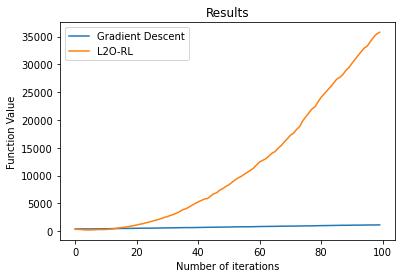

In [51]:
# model 8
plt.plot(val_gd, label= 'Gradient Descent')
plt.plot(val_rl, label= 'L2O-RL')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Function Value')
plt.title('Results')
plt.show()